<h2>Итоговая работа курса "Технологии анализа данных</h2>

Выполнил: Савченко Илья Николаевич<br>
Группа: W34602<br>
Номер ИСУ: 336951<br>

Я выбрал задачу 2: разведочный анализ некоторого набора данных + часть третьего задания с обучением модели

В качестве данных я выбрал датасет с сайта kaggle<br><br>
https://www.kaggle.com/datasets/nehalbirla/vehicle-dataset-from-cardekho

В нем представлены данные по различным автомобилям, ниже более детально указаны признаки, но для начала необходимо загрузить датасет.

In [37]:
DATA_PATH = "data/car_data.csv"

Импортируем библиотеки и загружаем датасет с помощью pandas

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2, mean_squared_error as mse
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [39]:
df = pd.read_csv(DATA_PATH, sep=",")

df.head(5)

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Car_Name       301 non-null    object 
 1   Year           301 non-null    int64  
 2   Selling_Price  301 non-null    float64
 3   Present_Price  301 non-null    float64
 4   Kms_Driven     301 non-null    int64  
 5   Fuel_Type      301 non-null    object 
 6   Seller_Type    301 non-null    object 
 7   Transmission   301 non-null    object 
 8   Owner          301 non-null    int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


<h2>Ознакомимся с признаками:</h2>

Перед нами датасет, содержащий информацию о 301 автомобиле с следующими характеристиками:

- **Car_Name**: Название автомобиля (object)
- **Year**: Год выпуска (int64)
- **Selling_Price**: Цена продажи (float64)
- **Present_Price**: Текущая цена (float64)
- **Kms_Driven**: Пробег в километрах (int64)
- **Fuel_Type**: Тип топлива (object)
- **Seller_Type**: Тип продавца (object)
- **Transmission**: Тип коробки передач (object)
- **Owner**: Количество владельцев (int64)

Таргетом у нас будет служить **Selling_Price** - Цена продажи

Пустых значений нет, посмотрим на количественные признаки

In [41]:
df_num_features = df.select_dtypes(include=['float64', 'float32', 'float16', 'int', 'int64'])
df_num_features.head()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
0,2014,3.35,5.59,27000,0
1,2013,4.75,9.54,43000,0
2,2017,7.25,9.85,6900,0
3,2011,2.85,4.15,5200,0
4,2014,4.60,6.87,42450,0


Посмотрим на распределение количественных признаков

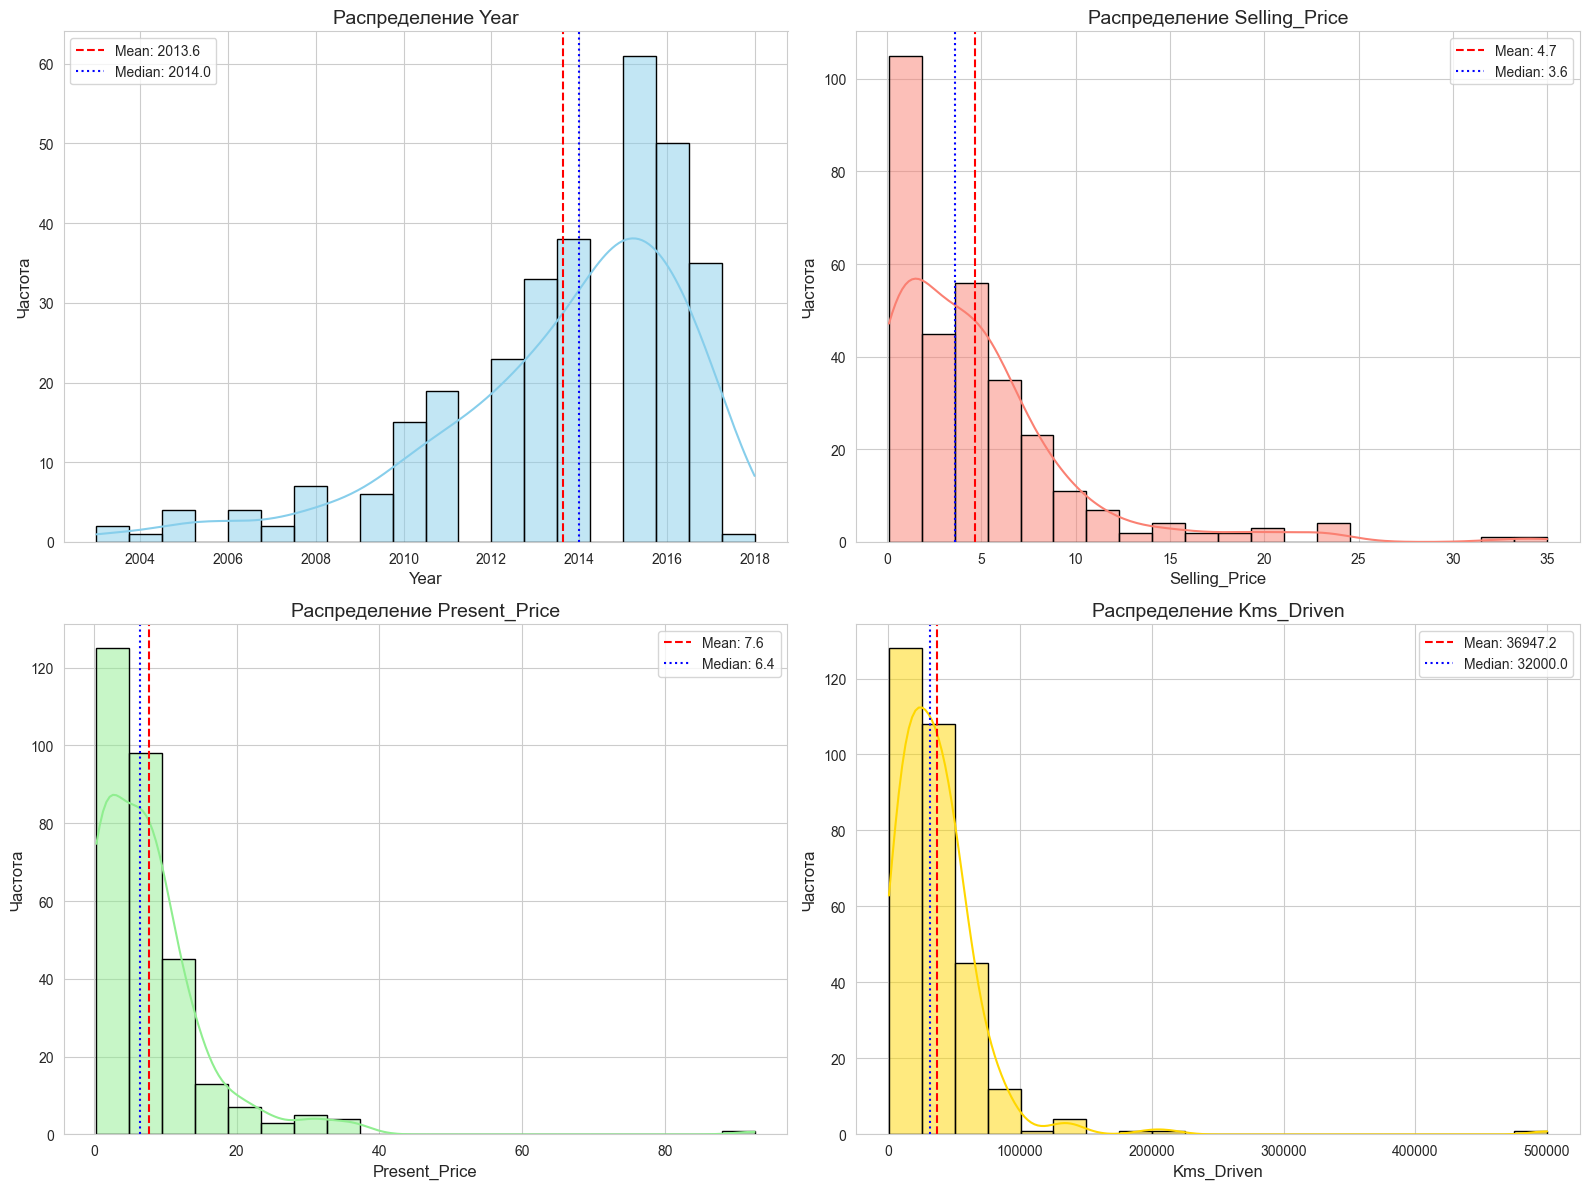

In [42]:
plt.figure(figsize=(16, 12))

features = ['Year', 'Selling_Price', 'Present_Price', 'Kms_Driven']
colors = ['skyblue', 'salmon', 'lightgreen', 'gold']

for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.histplot(df_num_features[feature], bins=20, kde=True, color=colors[i], edgecolor='black')
    
    # Среднее и медиана
    mean_val = df_num_features[feature].mean()
    median_val = df_num_features[feature].median()
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_val:.1f}')
    plt.axvline(median_val, color='blue', linestyle=':', linewidth=1.5, label=f'Median: {median_val:.1f}')
    
    # Заголовки и подписи
    plt.title(f'Распределение {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Частота', fontsize=12)
    plt.legend()

plt.tight_layout()
plt.show()

<h2>Избавимся от выбросов</h2>

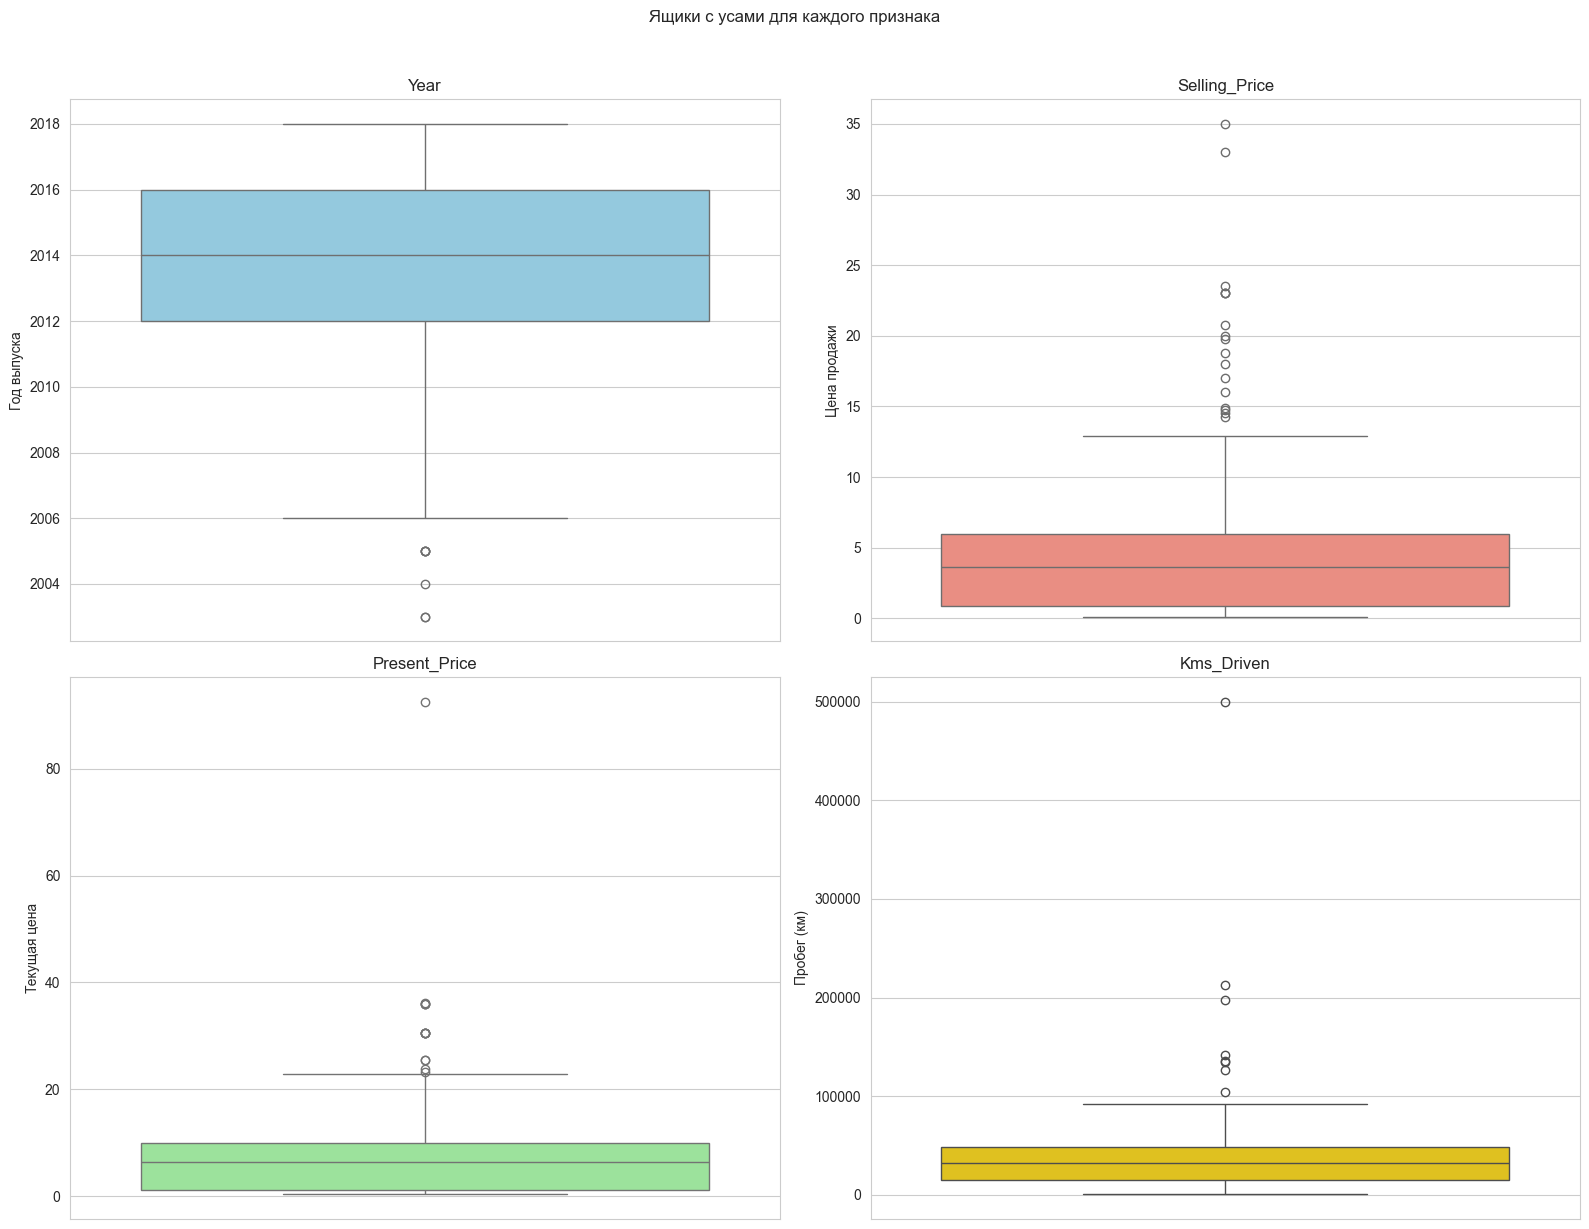

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Ящики с усами для каждого признака", y=1.02)

# Year
sns.boxplot(ax=axes[0, 0], y=df_num_features['Year'], color='skyblue')
axes[0, 0].set_title("Year")
axes[0, 0].set_ylabel("Год выпуска")

# Selling_Price
sns.boxplot(ax=axes[0, 1], y=df_num_features['Selling_Price'], color='salmon')
axes[0, 1].set_title("Selling_Price")
axes[0, 1].set_ylabel("Цена продажи")

# Present_Price
sns.boxplot(ax=axes[1, 0], y=df_num_features['Present_Price'], color='lightgreen')
axes[1, 0].set_title("Present_Price")
axes[1, 0].set_ylabel("Текущая цена")

# Kms_Driven
sns.boxplot(ax=axes[1, 1], y=df_num_features['Kms_Driven'], color='gold')
axes[1, 1].set_title("Kms_Driven")
axes[1, 1].set_ylabel("Пробег (км)")

plt.tight_layout()
plt.show()

С помощью квантилей определяем и убираем выбросы

In [44]:
def remove_outliers_iqr(df, column):
    """Удаление выбросов по квантилям."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [45]:
for column in df_num_features.columns:
    df_num_features = remove_outliers_iqr(df_num_features, column)

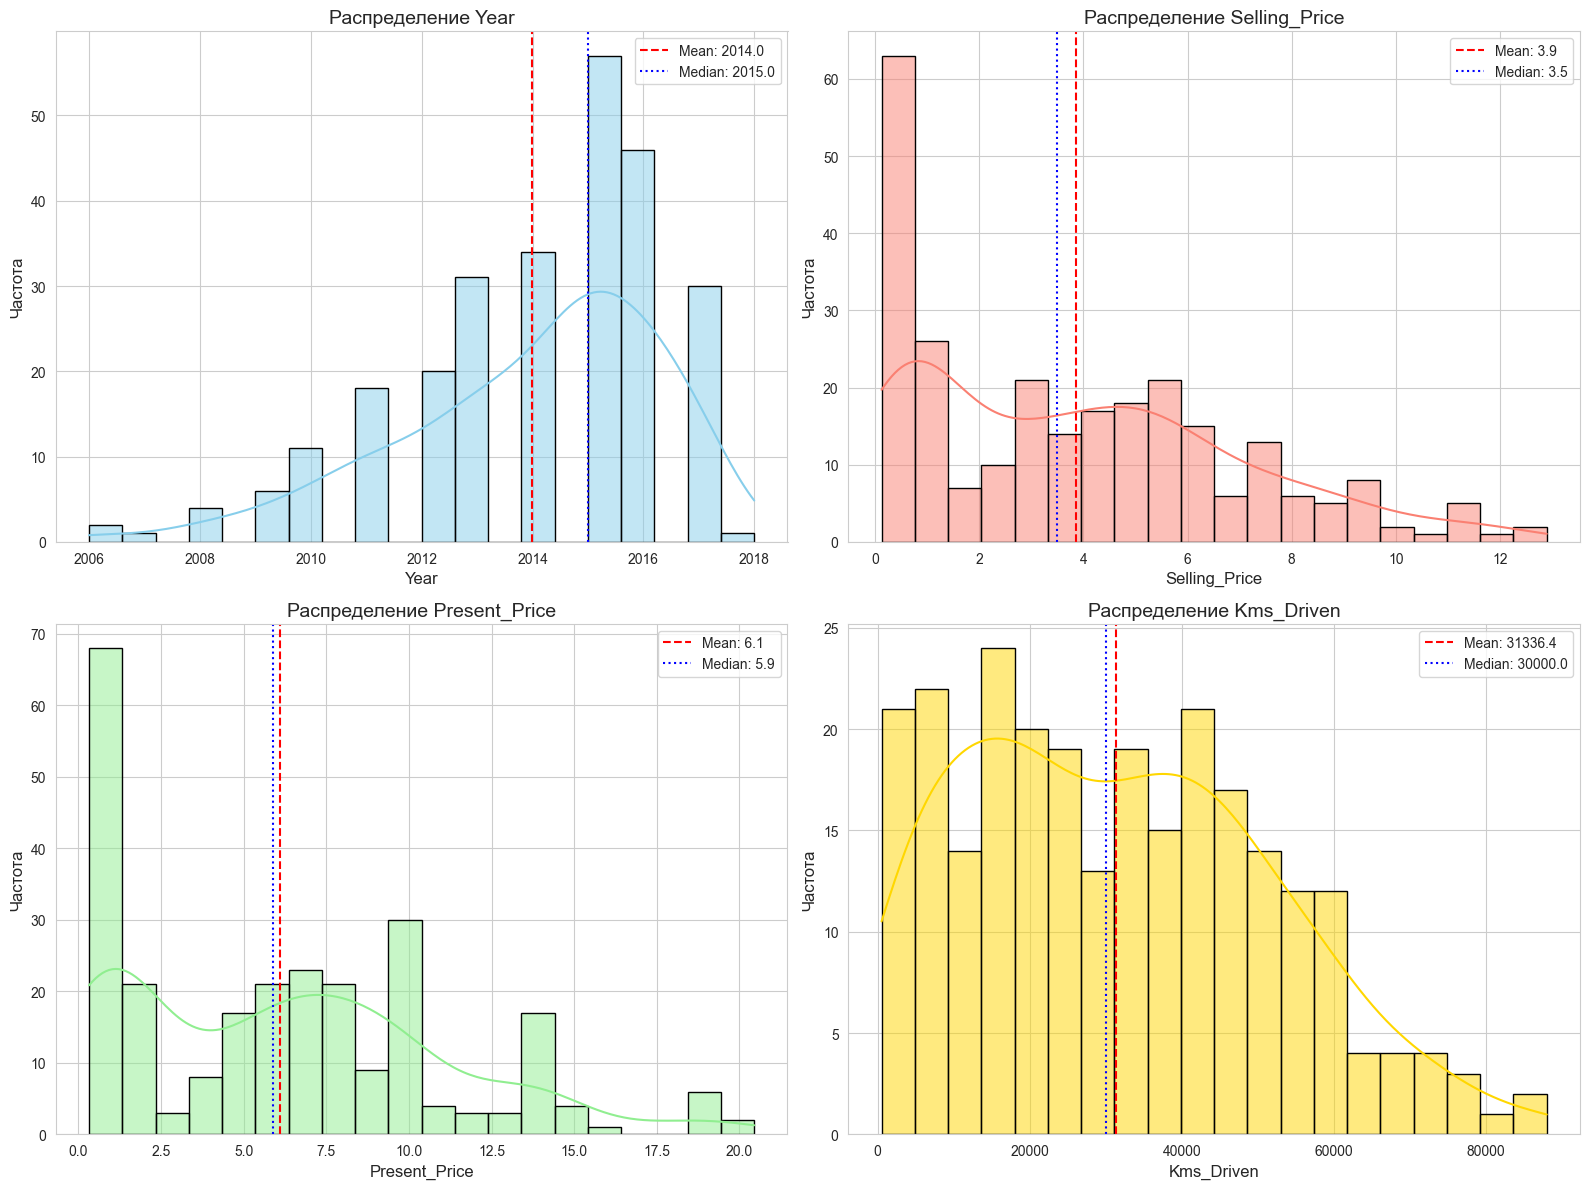

In [46]:
sns.set_style("whitegrid")
plt.figure(figsize=(16, 12))

features = ['Year', 'Selling_Price', 'Present_Price', 'Kms_Driven']
colors = ['skyblue', 'salmon', 'lightgreen', 'gold']

for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.histplot(df_num_features[feature], bins=20, kde=True, color=colors[i], edgecolor='black')

    mean_val = df_num_features[feature].mean()
    median_val = df_num_features[feature].median()
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {mean_val:.1f}')
    plt.axvline(median_val, color='blue', linestyle=':', linewidth=1.5, label=f'Median: {median_val:.1f}')
    
    plt.title(f'Распределение {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Частота', fontsize=12)
    plt.legend()

plt.tight_layout()
plt.show()

Видим, что выбросы пропали. Займемся категориальными признаками.

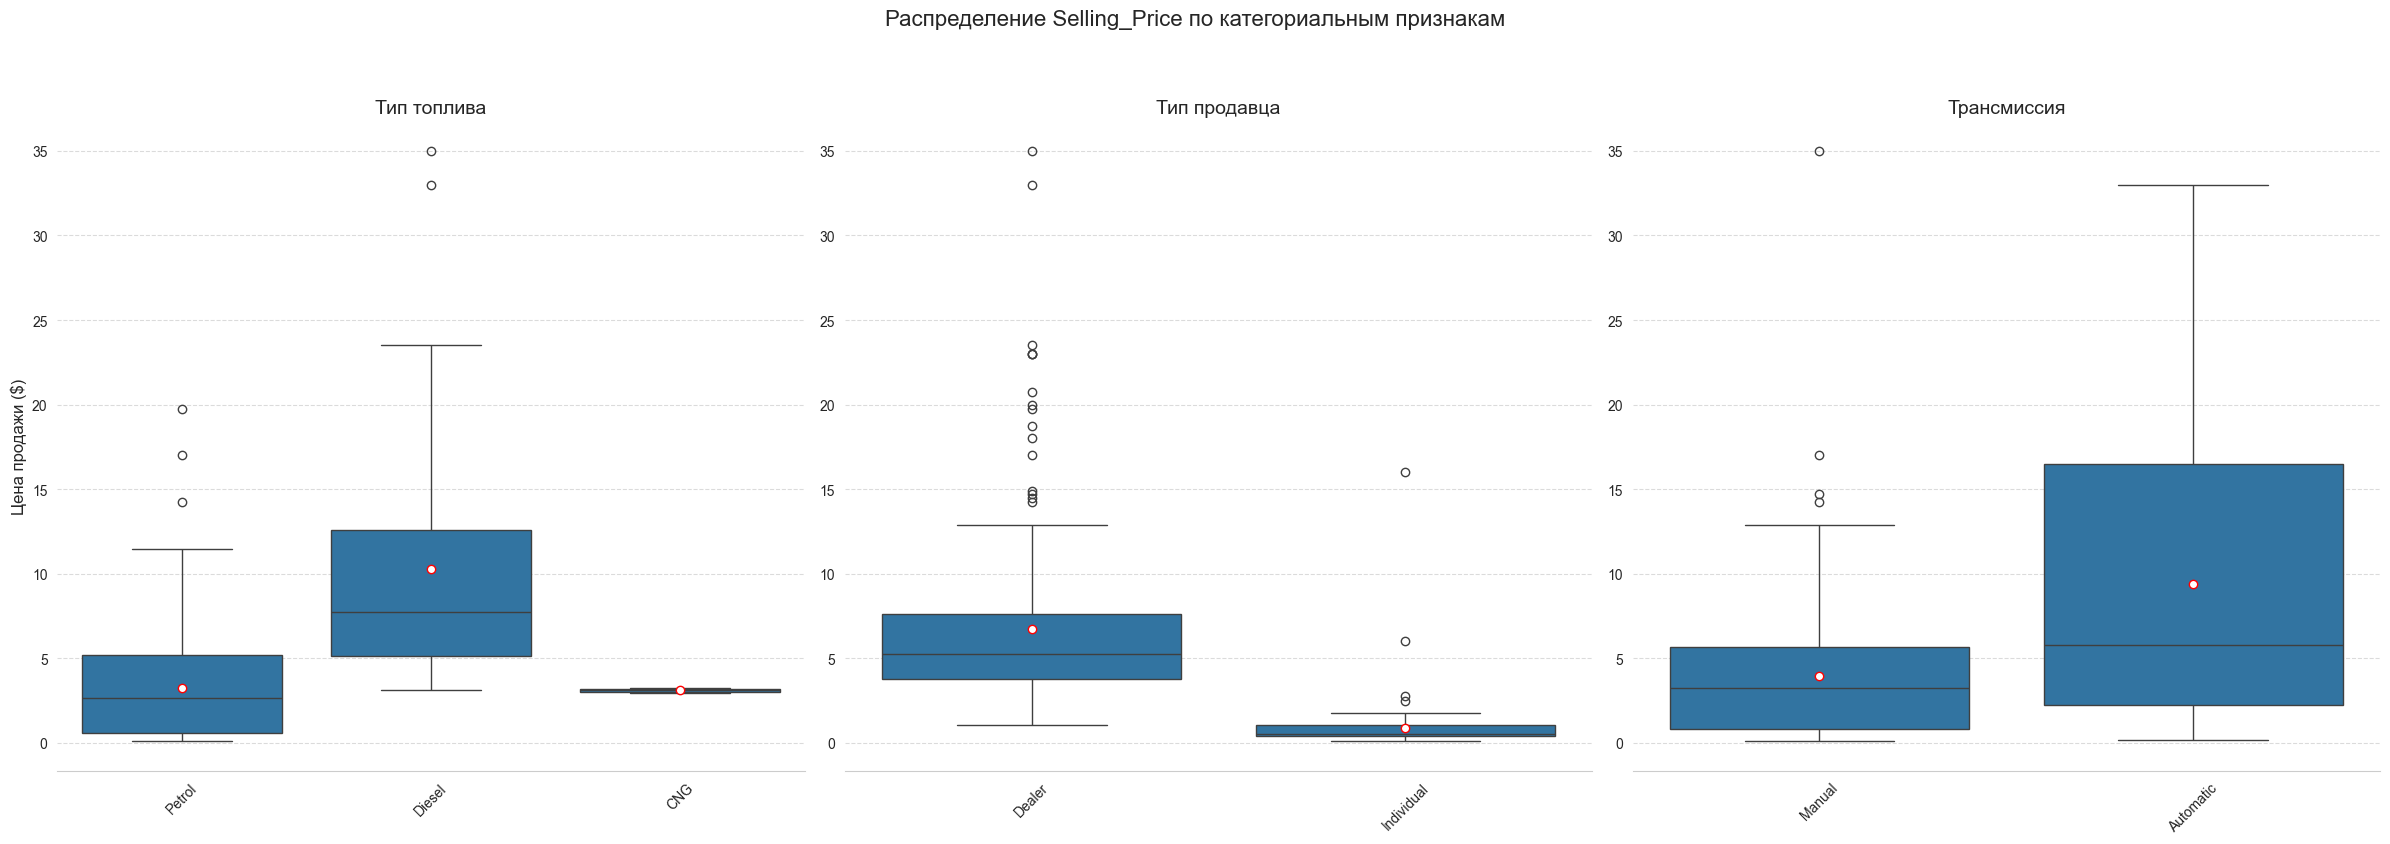

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('Распределение Selling_Price по категориальным признакам', y=1.05, fontsize=16)

sns.boxplot(ax=axes[0], y='Selling_Price', x='Fuel_Type', data=df, whis=1.5,
            showmeans=True, meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"red"})
axes[0].set_title('Тип топлива', fontsize=14)
axes[0].set_xlabel('')
axes[0].set_ylabel('Цена продажи ($)', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

sns.boxplot(ax=axes[1], y='Selling_Price', x='Seller_Type', data=df, whis=1.5,
            showmeans=True, meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"red"})
axes[1].set_title('Тип продавца', fontsize=14)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

sns.boxplot(ax=axes[2], y='Selling_Price', x='Transmission', data=df, whis=1.5,
            showmeans=True, meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"red"})
axes[2].set_title('Трансмиссия', fontsize=14)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

for ax in axes:
    ax.tick_params(axis='x', rotation=45)
    sns.despine(ax=ax, left=True)

plt.tight_layout()
plt.show()

Не рискну здесь делать очистку данных, лучше в дальнейшем преобразовать данные признаки в числовые.

<h2>Корелляции<h2>

Построим матрицу корелляций в поиске зависимостей

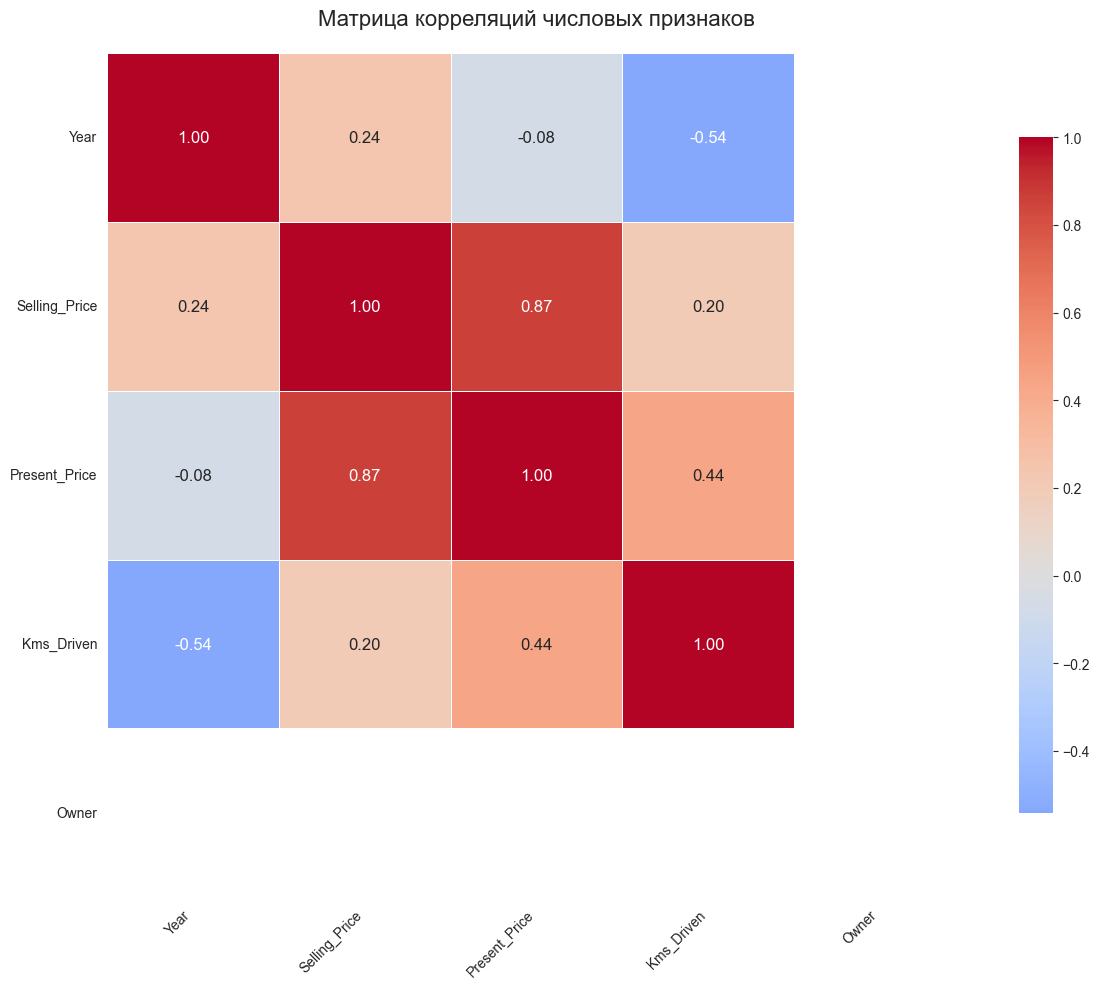

In [48]:
corr_matrix = df_num_features.corr()
plt.figure(figsize=(12, 10))

# Тепловая карта
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap="coolwarm",
            center=0,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
            annot_kws={"size": 12})

plt.title('Матрица корреляций числовых признаков', pad=20, fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.grid(visible=False)
plt.tight_layout()
plt.show()

Особо нет прямых корелляций, кроме как с Present_Price. Заодно посмотрим на зависимость цены от категориальных признаков.

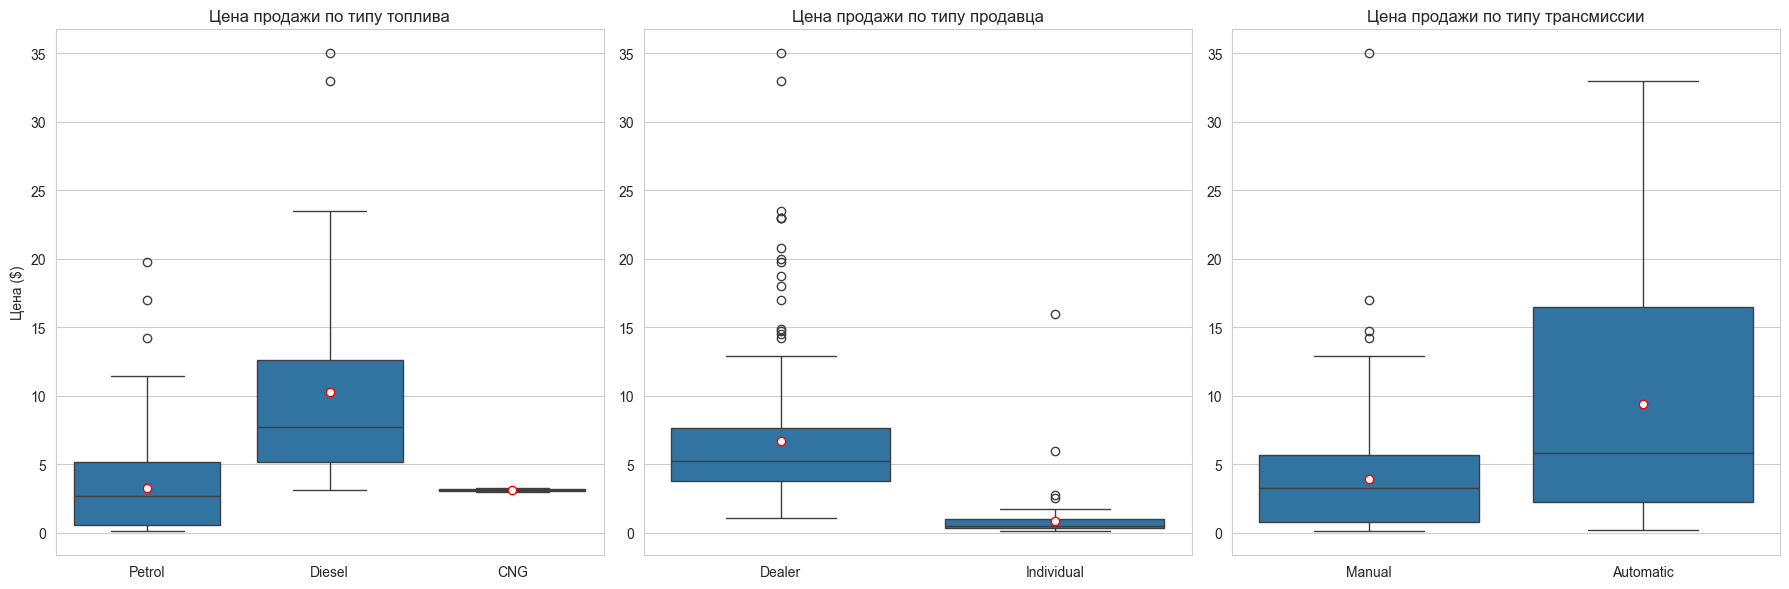

In [49]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.boxplot(x='Fuel_Type', y='Selling_Price', data=df, 
            showmeans=True, 
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"red"})
plt.title('Цена продажи по типу топлива')
plt.xlabel('')
plt.ylabel('Цена ($)')

plt.subplot(1, 3, 2)
sns.boxplot(x='Seller_Type', y='Selling_Price', data=df,
            showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"red"})
plt.title('Цена продажи по типу продавца')
plt.xlabel('')
plt.ylabel('')

plt.subplot(1, 3, 3)
sns.boxplot(x='Transmission', y='Selling_Price', data=df,
            showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"red"})
plt.title('Цена продажи по типу трансмиссии')
plt.xlabel('')
plt.ylabel('')

plt.tight_layout()
plt.show()

Из этих графиков четко видно то, что авто с автоматической трансмиссией / из салона / на дизельном топливе - стоят дороже аналогов с другими выриациями признаков

<h2>Будем строить модель для определения цены продажи авто</h2> 

Сначала подготовим функцию, которая будет возвращать нам метрики

In [50]:
def evaluate_preds(true_values, pred_values, test=False, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(5, 5))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 40], [0, 40], linestyle='--', color='black')
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig('report.png')
    
    if test:
        plt.gcf().set_facecolor('green')
    plt.show()

Теперь построим пайплайн для подготовки данных

In [51]:
class DataPipeline(BaseEstimator, TransformerMixin):
    """Класс для подготовки данных с улучшенной обработкой выбросов."""

    def __init__(self):
        self.iqr_bounds = {}
        self.medians = {}

    def fit(self, df, y=None):
        """Вычисление границ IQR и медиан для числовых признаков."""


        numeric_features = ['Present_Price', 'Kms_Driven', 'Selling_Price', 'Year']

        for feature in numeric_features:
            if feature in df.columns:
                Q1 = df[feature].quantile(0.25)
                Q3 = df[feature].quantile(0.75)
                IQR = Q3 - Q1
                
                self.iqr_bounds[feature] = {
                    'lower': Q1 - 1.5 * IQR,
                    'upper': Q3 + 1.5 * IQR
                }
                self.medians[feature] = df[feature].median()
        
        return self
    
    def transform(self, df, y=None):
        """Трансформация данных с обработкой выбросов."""
        
        df = df.copy()
        
        for feature, bounds in self.iqr_bounds.items():
            if feature in df.columns:
                median_val = self.medians[feature]
                df.loc[df[feature] < bounds['lower'], feature] = median_val
                df.loc[df[feature] > bounds['upper'], feature] = median_val

        if 'Fuel_Type' in df.columns:
            fuel_mapping = {"Petrol": 1, "Diesel": 2, "CNG": 3}
            df['Fuel_Type'] = df['Fuel_Type'].map(fuel_mapping)
            
        if 'Seller_Type' in df.columns:
            seller_mapping = {"Dealer": 0, "Individual": 1}
            df['Seller_Type'] = df['Seller_Type'].map(seller_mapping)
            
        if 'Transmission' in df.columns:
            transmission_mapping = {"Manual": 0, "Automatic": 1}
            df['Transmission'] = df['Transmission'].map(transmission_mapping)
        
        cols_to_drop = ['index', 'id', 'Car_Name']
        for col in cols_to_drop:
            if col in df.columns:
                df.drop(columns=col, inplace=True)
                
        return df

Добавим также стандартизацию

In [52]:
pipe = make_pipeline(
    DataPipeline(),
    StandardScaler()
)
pipe

Pipeline(steps=[('datapipeline', DataPipeline()),
                ('standardscaler', StandardScaler())])

<h3>Воспользуемся простейшей моделью линейной регрессии</h3>

Делим данные и трансформируем их

In [53]:
df = pd.read_csv("data/car_data.csv", sep=",")
X = df.drop(columns='Selling_Price')
Y = df['Selling_Price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=True, random_state=42)

In [54]:
pipe.fit(X_train, Y_train)

X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

<h2>Первый запуск</h2>

R2:	0.573
RMSE:	3.277
MSE:	10.738


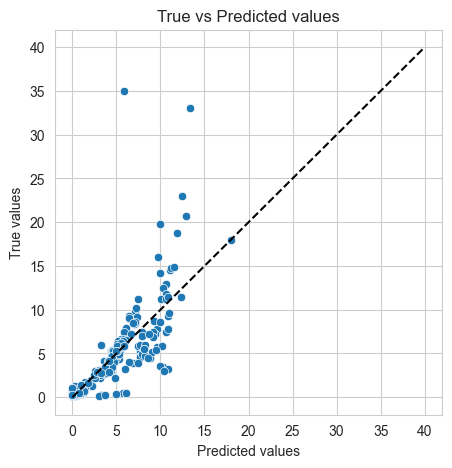

In [55]:
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)

y_train_preds = lr_model.predict(X_train)
# Добавили постпроцессинг
y_train_preds = np.clip(y_train_preds, a_min=0, a_max=50)

# Результаты на тренировочных данных
evaluate_preds(Y_train, y_train_preds)

R2:	0.627
RMSE:	3.201
MSE:	10.248


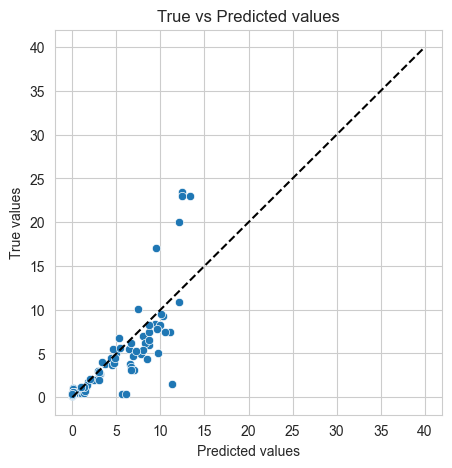

In [56]:
y_test_preds = lr_model.predict(X_test)
y_test_preds = np.clip(y_test_preds, a_min=0, a_max=50)

# Результаты на тестовых данных
evaluate_preds(Y_test, y_test_preds)

Как видно по метрикам - результаты пока средние. Добавим полиномиальные признаки

<h2>Второй запуск</h2>

In [57]:
pipe = make_pipeline(
    DataPipeline(),
    StandardScaler(),
    PolynomialFeatures(interaction_only=True),
)
pipe

Pipeline(steps=[('datapipeline', DataPipeline()),
                ('standardscaler', StandardScaler()),
                ('polynomialfeatures',
                 PolynomialFeatures(interaction_only=True))])

R2:	0.777
RMSE:	2.368
MSE:	5.606


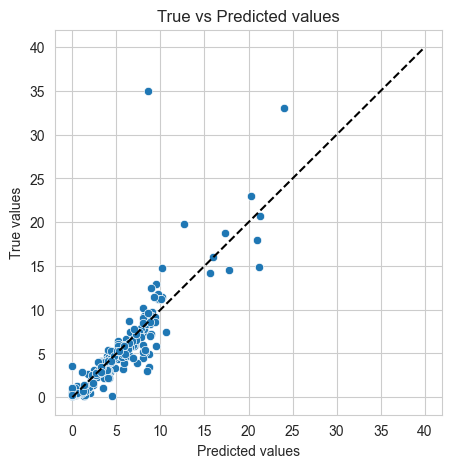

In [58]:
X = df.drop(columns='Selling_Price')
Y = df['Selling_Price']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=True, random_state=42)
pipe.fit(X_train, Y_train)

X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)

y_train_preds = lr_model.predict(X_train)
y_train_preds = np.clip(y_train_preds, a_min=0, a_max=50)

# Результаты на тренировочных данных
evaluate_preds(Y_train, y_train_preds)

R2:	0.923
RMSE:	1.456
MSE:	2.121


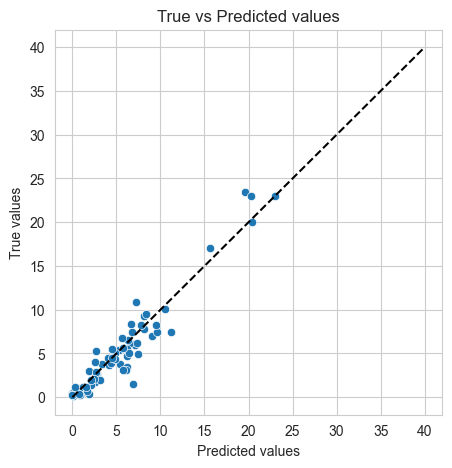

In [59]:
y_test_preds = lr_model.predict(X_test)
y_test_preds = np.clip(y_test_preds, a_min=0, a_max=50)

# Результаты на тестовых данных
evaluate_preds(Y_test, y_test_preds)

Полиномиальное перемножение дало значительный буст нашей модели, пока сохраним ее. Но эксперименты продолжим

In [60]:
import pickle


def save_model(lr_model):
    """Функция для сохранения версии модели."""
    with open("linear_model.pkl", 'wb') as filename:
        pickle.dump(lr_model, filename)

save_model(lr_model)

<h2>Эксперименты со степенями</h2>

Добавим степень полинома. Сделаем функцию с кросс-проверкой

In [61]:
def cross_check(n: int = 1, cols: list = ['Selling_Price']):
    """Функция для кросс-валидации полиномиальных перемножений"""

    pipe = make_pipeline(
        DataPipeline(),
        StandardScaler(),
        PolynomialFeatures(degree=n),
    )
    pipe

    X = df.drop(columns=cols)
    Y = df['Selling_Price']

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=True, random_state=42)
    pipe.fit(X_train, Y_train)

    X_train = pipe.transform(X_train)
    X_test = pipe.transform(X_test)

    lr_model = LinearRegression()
    lr_model.fit(X_train, Y_train)

    y_train_preds = lr_model.predict(X_train)
    y_train_preds = np.clip(y_train_preds, a_min=0, a_max=50)

    evaluate_preds(Y_train, y_train_preds)

    y_test_preds = lr_model.predict(X_test)
    y_test_preds = np.clip(y_test_preds, a_min=0, a_max=50)

    evaluate_preds(Y_test, y_test_preds)

    return lr_model

R2:	0.787
RMSE:	2.314
MSE:	5.353


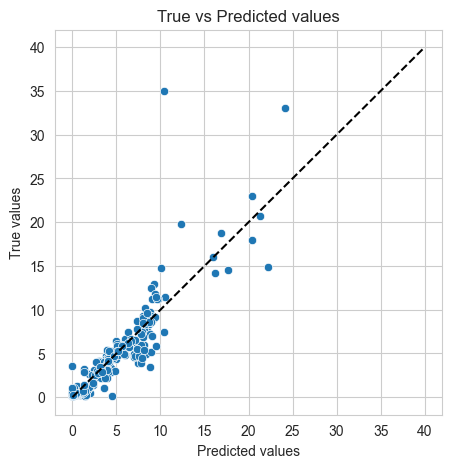

R2:	0.907
RMSE:	1.598
MSE:	2.555


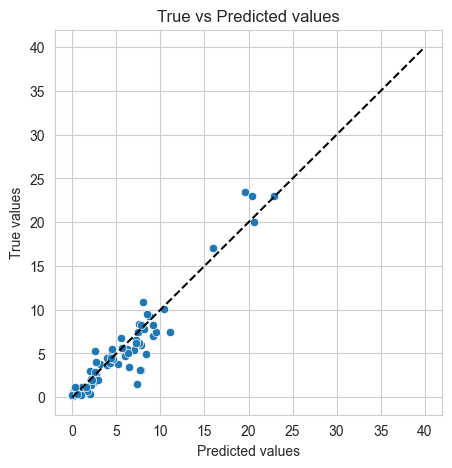

In [62]:
lr_model = cross_check(2)

R2:	0.953
RMSE:	1.091
MSE:	1.191


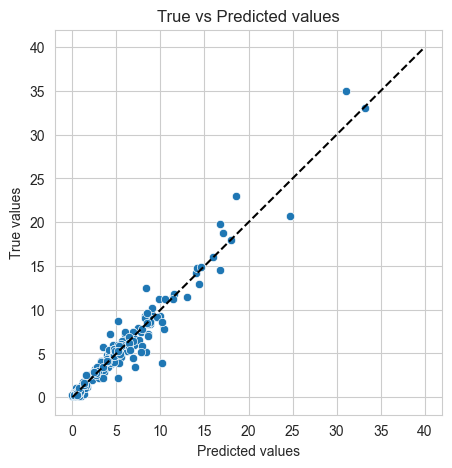

R2:	0.68
RMSE:	2.967
MSE:	8.804


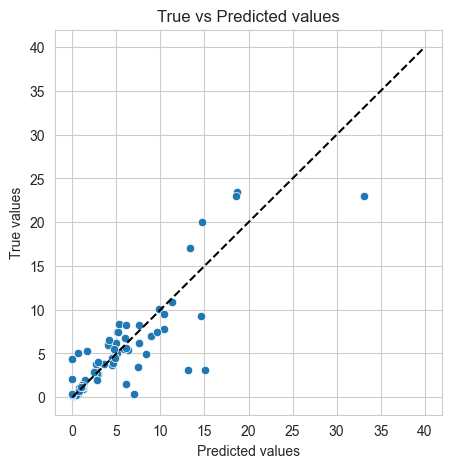

In [63]:
lr_model = cross_check(3)

Здесь уже началось переобучение. Эксперименты не принесли успеха, поэтому итоговая модель будет та, которую мы сохраниили ранее.

<h2>Выводы</h2>

В ходе данной работы мною был проанализирован датасет. Был выполнен разведочный анализ, визулизация, трансформация данных + построение и кросс-валидация простейшей модели (linear_model.pkl)